# Selecting the best model

## (1) Overfitting and underfitting (Sven)

### Cross-validation framework

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target

In [2]:
# To simplify future visualization, let’s transform the prices from the 100 (k$) range to the thousand dollars (k$) range.
target *= 100
target.head()

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64

#### Training error vs testing error

Trying without train/test split

In [3]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(data, target)

DecisionTreeRegressor(random_state=0)

In [4]:
from sklearn.metrics import mean_absolute_error

target_predicted = regressor.predict(data)
score = mean_absolute_error(target, target_predicted)
print(f"On average, our regressor makes an error of {score:.2f} k$")

On average, our regressor makes an error of 0.00 k$


In [5]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0
)

In [6]:
regressor.fit(data_train, target_train)

DecisionTreeRegressor(random_state=0)

In [7]:
target_predicted = regressor.predict(data_train)
score = mean_absolute_error(target_train, target_predicted)
print(f"The training error of our model is {score:.2f} k$")

The training error of our model is 0.00 k$


In [8]:
target_predicted = regressor.predict(data_test)
score = mean_absolute_error(target_test, target_predicted)
print(f"The testing error of our model is {score:.2f} k$")

The testing error of our model is 47.28 k$


Cross-validation: estimate robustness of a predictive model by repeating the splitting procedure. Gives several training and testing errors and 
therefore we can estimate how much the model generalization performance varies (as a an approximation to the "new" data that arrive in production). 

shuffle split
- make copy of dataset where order of observations are shuffled
- make train/test split
- train model on train, evaluate on test


In [9]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)
# this creates 40 cv splits, where 30% of records are in test data set
cv_results = cross_validate(
    regressor, data, target, cv=cv, scoring="neg_mean_absolute_error"
)
# the ShuffleSplit repeatedly spits out the shuffled train/test splits and lets sklearn train a new model on the train data and evaluate on the test data.

In [10]:
# just some intuition for what ShuffleSplit does
for train_index, test_index in cv.split(data): # TODO: this is not course material. is it useful anyway?
    print("%s %s" % (train_index, test_index))

[ 1989   256  7887 ...  9845 10799  2732] [14740 10101 20566 ... 10211  2445 17914]
[ 3364 16548  7361 ...  5154 14875  2751] [ 9959 16306 17662 ... 20549  1212 17484]
[12518 17324  1688 ...  9972  1146   747] [20340 18230 15362 ...  2035  6919  6461]
[15912   555  5108 ... 14722  5851 12988] [ 5313  7640 18918 ...  5008  3312 18057]
[10604  1016  3266 ...   526  6465  9283] [ 7357  4713 10050 ...  1544 11416  6346]
[20356 13340  7263 ... 10572 16502 14054] [10502 14461 10915 ...  8940  5024  3583]
[ 9803  7879 11052 ... 13881  1853 13042] [13182  1320  2362 ... 13276 18258  7491]
[17232 19201 13640 ... 10609  1597 11674] [ 3344   302 20417 ... 12118 15635  5754]
[18558  3153  8256 ...  2442 16057 18358] [ 5997   295  2025 ...  4540 15907  1990]
[10931  6653 19020 ... 19800  6174 10120] [ 6580 14013 12559 ... 14312 13338  7646]
[ 7407 10308 16190 ...  8158 20388  3002] [10768 10864  2580 ... 11360  4314  4105]
[  719 18917  5337 ...    83 10723  3340] [14615  4459  3043 ... 13013 17231

Note: some of these things are covered in the "Overfitting and underfitting section", thus it may not be necessary to cover them again/in detail

What does the `ShuffleSplit` do? 
- https://scikit-learn.org/stable/modules/cross_validation.html#random-permutations-cross-validation-a-k-a-shuffle-split
- https://stackoverflow.com/questions/34731421/whats-the-difference-between-kfold-and-shufflesplit-cv
- it creates train and test samples randomly in each iteration. this means that a single observation can be multiple times in the test set.

parameters
- `n_splits`: the number of train-test splits
- `test_size`: size of test data, as a fraction of the full data set
- `random_state`: makes the results reproducible b/c it fixes tells the random number generator where to start randomizing

We can pass this input to the cross_validate function below as the `cv` argument.



In [11]:
import pandas as pd

cv_results = pd.DataFrame(cv_results)
cv_results.head()

,fit_time,score_time,test_score
0,0.134735,0.002323,-46.909797
1,0.117729,0.002699,-46.421170
2,0.118868,0.002216,-47.411089
3,0.120171,0.002175,-44.319824
4,0.117533,0.002098,-47.607875


Lingo: score vs error
- score = higher values mean better results
- error = lower values mean better results

`scoring` parameter in `cross_validate` expects a function that is a score (why does that matter? does it not just calculate the error/score and return it? does it do something with it?)

so, the mean abs error is an error, but we need a score -- so we take the negative. But to look at the mean absolute error for our purpose, we need to again re-convert the score to an error.

In [12]:
cv_results["test_error"] = -cv_results["test_score"]

In [13]:
cv_results.head()

,fit_time,score_time,test_score,test_error
0,0.134735,0.002323,-46.909797,46.909797
1,0.117729,0.002699,-46.421170,46.421170
2,0.118868,0.002216,-47.411089,47.411089
3,0.120171,0.002175,-44.319824,44.319824
4,0.117533,0.002098,-47.607875,47.607875


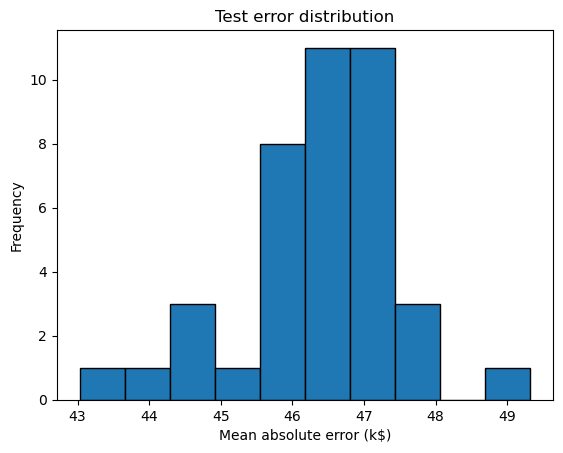

In [14]:
import matplotlib.pyplot as plt

cv_results["test_error"].plot.hist(bins=10, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Test error distribution")

What does this mean? <mark> Call-out? </mark>
>We notice that the mean estimate of the testing error obtained by cross-validation is a bit smaller than the natural scale of variation of the target variable. Furthermore, the standard deviation of the cross validation estimate of the testing error is even smaller.

- mean estimate of testing error is 47k
- what is the "natural scale of variation of the target variable"? -- it is just the range of the outcome, from around 50k to 500k
- but then I don't understand 47k is "a bit smaller than the range", which is 500k?
- small std of cross-validated error indicates good out-of-sample performance of the model


## (2) Validation and learning curves

### Comparing train and test errors

See the video/slides: https://inria.github.io/scikit-learn-mooc/overfit/learning_validation_curves_slides.html

Presentation notes 

train vs test error
- black training data points
- fit blue prediction function
- orange test data (generalization error). -- fundamental goal of ML: good prediction of y given x on unseen data.
- we can contrast the train and test error to understand better how well it generalizes

**train vs test error: increasing complexity**
- polynomial: higher degree = higher complexity. first order = linear in x. second-order = quadratic in x. etc.
- compare the train and test error: average distance between the blue prediction line and the respective data points.
- on average, train error < test error b/c it's easier to remember the training data
- degree 2 polynomial: lowers both train and test error
- degree 5 poly: train error decreases further; but it seems it fits some noise in the training data that are not present in the test data (the very right of the figure). thus, test error increases.
- degree 9 poly: gets extreme.
- in sum: get an intuition of how a more complex model impacts train and test error: low degree poly -> train and test error are high. higher complexity -> "sweet spot" test error is minimal. higher complexity -> test error gets higher again. *overfitting*

**train vs test error: varying the sample size**
- fix the complexity of the model; see how a bigger training set impacts the test error
- few data points -> function varies.
- adding data points -> function gets smoother. test error goes down. intuition: the model can approximate the true data generating process better; noise in the training data has smaller impact on the prediction. (train error also increases; but reason not clear)
- at some point, the train and test error ar the same, suggesting we're close to the optimal model
- going beyond it -> no more changes; "diminishing returns". if computation is costly, this is mostly adding costs without adding value
- *with large enough training data, the degree 9 poly does not overfit anymore*
- general pattern: model complexity *relative* to the training data
- we cannot bring the test error to 0: "Bayes error rate" / "irreducible error" -- arises from the random noise that is in the data generating process. *best we can do*


**model families**
- in ML, we always have a statistical model, and an unknown data-generating process
- by choosing the statistical model, we want to match the DGP
- so far, we had polynomials for both DGP and the stat model
- we can also choose a different model family. what happens then?
- decision tree: piece-wise linear: predict constant y for a range of x. (blue line)
- they have different inductive biases and different notions of complexity
- inductive bias = "the set of assumptions that the learner uses to predict outputs of given inputs that it has not encountered."
- there is always an inductive bias *unless* we choose the correct model class that matches the DGP
- model families have different notions of complexity: higher degrees in polynomial = higher number of splits in the decision tree. both lead to overfitting.
- regularization = favor smooth, simple functions over complex functions. this reduces overfitting. *change parameters while keeping the model fixed*

**take-home messages**
- models overfit when number of examples in the training set is too small compared to the complexity of the model
- we can detect overfitting when the testing error is much bigger than the training error (but not necessarily? -- better to "minimize test error"?)
- models underfit if they fail to capture the shape of the training set -> even the training error is large. BUT: it could also be noise in the DGP.

We'll see how this works in practice now.



### Overfit-generalization-underfit

We now want to use the cross-validation approach to quantify training and testing errors. This helps us to find out whether our model generalizes, overfits or underfits.

In [15]:
# already done above
# housing = fetch_california_housing(as_frame=True)
# data, target = housing.data, housing.target # we just extract the explanatory variables and the outcome
# target *= 100 # rescale the target to thousands of dollars (the original data are in hundreds of thousands of dollars) 
# # https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html


In [16]:
# target.head()

In [17]:
# from sklearn.tree import DecisionTreeRegressor

# regressor = DecisionTreeRegressor()

# DELETE?


The decision tree regressor was "introduced" / used (but not explained) in the previous segment.

#### Overfitting vs underfitting


In order to understand how our model generalizes, we want to compare the testing and the training error. To compute the error on the test set with the `cross_validate` function

In [18]:
# already imported above
# from sklearn.model_selection import cross_validate, ShuffleSplit

In [19]:
cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=0)

In [20]:
cv_results = cross_validate(
    regressor,
    data,
    target,
    cv=cv,
    scoring="neg_mean_absolute_error",
    return_train_score=True,
    n_jobs=2,
)

In [21]:
cv_results

{'fit_time': array([0.15901041, 0.15462327, 0.14369011, 0.14404035, 0.13351107,
        0.15129304, 0.13570118, 0.15595984, 0.13709831, 0.15563917,
        0.1382761 , 0.13780141, 0.14230585, 0.1352129 , 0.13348413,
        0.13836837, 0.13418651, 0.13779807, 0.13718748, 0.14034796,
        0.13443398, 0.13722944, 0.13685179, 0.14045691, 0.13579845,
        0.1356163 , 0.14474726, 0.14174986, 0.13976908, 0.13761449]),
 'score_time': array([0.00211239, 0.00247335, 0.00182414, 0.00187087, 0.00188708,
        0.00208926, 0.00185013, 0.00192165, 0.00216556, 0.00203633,
        0.00193024, 0.00200391, 0.00206995, 0.00203156, 0.00213957,
        0.00203466, 0.00181746, 0.00215149, 0.00189781, 0.00222826,
        0.00189853, 0.00200653, 0.00207996, 0.00211382, 0.00194407,
        0.00215816, 0.00210381, 0.00231051, 0.00191712, 0.00191021]),
 'test_score': array([-46.92525848, -46.6962173 , -45.06884133, -43.57765528,
        -48.05169307, -44.58310441, -44.42208236, -45.1216984 ,
        -44.

In [22]:
cv_results = pd.DataFrame(cv_results)

In [23]:
cv_results

,fit_time,score_time,test_score,train_score
0,0.159010,0.002112,-46.925258,-1.517477e-14
1,0.154623,0.002473,-46.696217,-3.297965e-15
2,0.143690,0.001824,-45.068841,-9.325873e-15
3,0.144040,0.001871,-43.577655,-1.263761e-14
4,0.133511,0.001887,-48.051693,-8.812933e-15
5,0.151293,0.002089,-44.583104,-1.258597e-14
6,0.135701,0.001850,-44.422082,-1.440708e-14
7,0.155960,0.001922,-45.121698,-3.745497e-15
8,0.137098,0.002166,-44.960310,-1.121239e-14
9,0.155639,0.002036,-45.140519,-3.459765e-15


we used the negative mean abs error (higher is better) $\rightarrow$ let's transform it into a positive mean abs error (smaller is better) 
- this is the same as we did in the previous segment on overfitting and underfitting


In [24]:

scores = pd.DataFrame()
scores[["train error", "test error"]] = -cv_results[
    ["train_score", "test_score"]
]

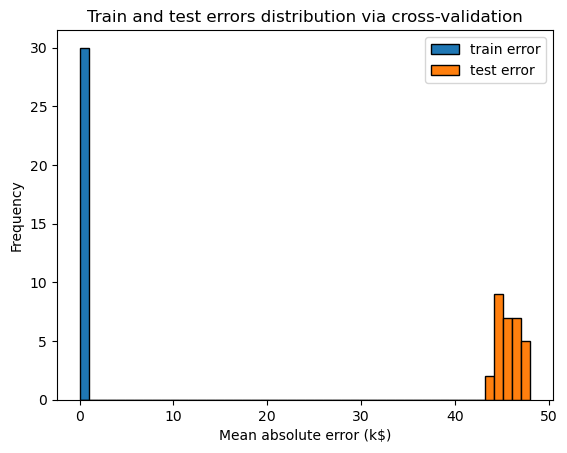

In [25]:
import matplotlib.pyplot as plt 
scores.plot.hist(bins=50, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Train and test errors distribution via cross-validation")

What do we see here?  <mark> Call-out? </mark>
- train error is very small, actually 0. thus, the model is certainly not underfitting
- test error is much larger -- indicates that we are overfitting.
- **intuition**: the model is memorized too many observations from the training set. because there is some extent of noise in all observations, this means that the memorized observations do not replicate in the test dataset, leading to high test error.

#### Validation curve

hyperparameters: 
- parameters that are not directly learned in the training process, but are chosen by us and can impact the performance of the model
- for instance: the number of neighbors in a k-nearest neighbors model
- the degree of a polynomial


Often, choosing the right hyperparameters is crucial to move a model towards a better test set performance (be it moving away from underfitting or from overfitting)

We can find how the training and test erorrs behave as a function of the hyperparameters with the **validation curve**. 

Let's apply to curve to our example from above: we can use the `max_depth` hyperparameter and see how the trade-off between over- and underfitting behaves.


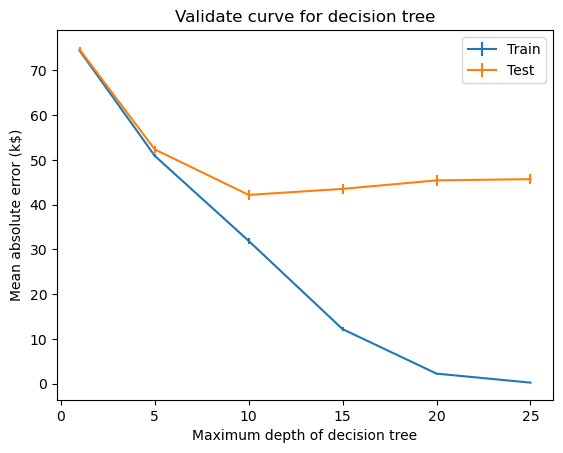

In [28]:
import numpy as np 
from sklearn.model_selection import ValidationCurveDisplay

max_depth = np.array([1, 5, 10, 15, 20, 25]) # this defines the depth of a tree

disp = ValidationCurveDisplay.from_estimator(
    regressor,
    data,
    target, 
    param_name="max_depth", # I guess this needs to be a parameter of the respective regressor model?
    param_range=max_depth, 
    cv=cv, # we re-use the shuffle split from above
    scoring="neg_mean_absolute_error",
    negate_score=True, ## this again re-converts the neg_mean_absolute_error to the mean_absolute_error
    std_display_style="errorbar", # show the variability of the mean absolute error
    n_jobs=2,
)

_ = disp.ax_.set(
    xlabel="Maximum depth of decision tree",
    ylabel="Mean absolute error (k$)",
    title="Validate curve for decision tree",
)


<mark> explain the regression tree? what is the depth? </mark>
- simply put: the deeper, the more flexible the tree because it uses more features for explaining the outcome


There are 3 areas in the validation curve

- first, we'd like to be in a sweet spot between neither over- nor underfitting. (mention bias-variance trade-off??)
- this is equivalent to the lowest possible test error, in this case with a depth of around 10. here we say "the model generalizes".
- the other regions are worse because the test error is larger
   - for `max_depth` < 10, we underfit: both train and test error are large
   - for `max_depth` > 10, we overfit: training error becomes very small, but test error increases. "memorizing" of observations and too much associated noise.

<mark> in how much detail should I explain this? use it as exercise? </mark>


**Notes**
- we should not only look at the mean errors, but also at the standard deviation of the errors
   - why? -- for two types of hyperparameters, we could have the same mean errors, but a much larger variance. in this case, we would like to go for the model with lower variance. this is actually displayed with the error bars in the figure above (with the `std_display_style` attribute. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ValidationCurveDisplay.html)
   - in our case, the variance seems to be fairly stable across hyperparameter values
- we see also that the train and test error slightly diverge for `max_depth` = 10 already. Thus, the model might be overfitting. But this is the best we can do with changing the hyperparameter. 

#### Summary
- how to identify whether a model is generalizing, overfitting or underfitting
- how to check the influence of a hyperparameter on the underfit/overfit tradeoff



### Effect of the sample size in cross-validation

- before: how under-/overfitting and generalizing are impacted by hyperparameter values
- now: how they are impacted by the size of the data we have available


In [27]:
# already done above
# housing = fetch_california_housing(as_frame=True)
# data, target = housing.data, housing.target
# target *= 100  

# we already have the DecisionTreeRegressor

#### Learning curve

- we can produce similar figures with test and train errors by varying the size of the dataset
- this called the **learning curve**
- it is informative about whether adding more training data improves the model's generalization performance

In [28]:
train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True) # we split the values from 0.1 to 1 into 5 equally-sized parts
# endpoint=True includes also 1.0.
train_sizes

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

In [29]:
# again use a ShuffleSplit for cross-validation
cv = ShuffleSplit(n_splits=30, test_size=0.2)

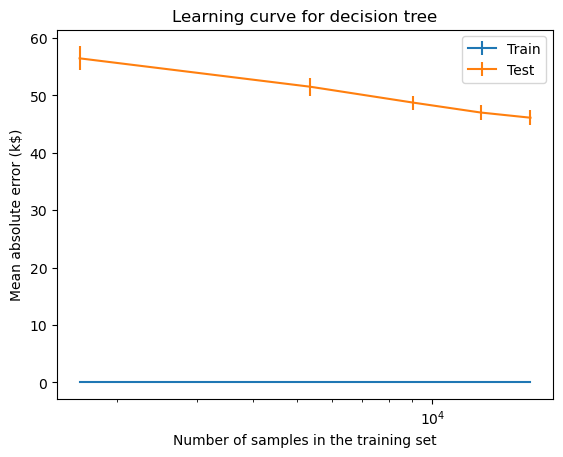

In [30]:
# let's do the experiment
from sklearn.model_selection import LearningCurveDisplay

display = LearningCurveDisplay.from_estimator(
    regressor,
    data,
    target,
    train_sizes=train_sizes,
    cv=cv,
    # score_type="both", # score both train and test errors -- this is the default, and not shown in the previous segment
    # to make it consistent, ignore it here
    scoring="neg_mean_absolute_error",
    negate_score=True,
    score_name="Mean absolute error (k$)",
    std_display_style="errorbar",
    n_jobs=2,
)
_ = display.ax_.set(xscale="log", title="Learning curve for decision tree")

What do we see?
- train error is 0 -- overfitting
- the variability of the error declines as we increase the size of the data set -- noise has less impact on the error
- test error declines as we increase sample size
- since it does not seem to "flatten out", we it may be useful to increase the size of the dataset further to reduce the test error
- in case we reached the "flat" part of the learning curve, then we may have reached the Bayes error rate (the irreducible error, ie  $Var(\varepsilon)$) with the available model. To further reduce the test error, we'd have to try ot a more complex model.

#### Summary
- we can use the learning curve to check whether it's worth adding more data, or whether we may need to try out a more complex model

### Exercise M2.01

**For the questions, see the exercise document**

**<mark> explain what the SVM does? </mark>**

for classification problems:
- in a $p$-dimensional space, tries to find a boundary in $p-1$-dimensional space to separate the data points
- give example with 2-dimensional space?
- it seeks to maximize the distance from the closest data points on either side of the boundary
   - intuition: this will also lead to low generalization error (since "new" data are likely to fall into the same area as the "existing" data)
- see wikipedia: https://en.wikipedia.org/wiki/Support_vector_machine -- the $\gamma$ parameter is in the radial basis function

what is the $\gamma$ parameter? it makes the classification boundary more non-linear. 

#### Solution

In [31]:
blood_transfusion = pd.read_csv("../datasets/blood_transfusion.csv")
data = blood_transfusion.drop(columns="Class")
target = blood_transfusion["Class"]

In [32]:
data.head()

,Recency,Frequency,Monetary,Time
0,2,50,12500,98
1,0,13,3250,28
2,1,16,4000,35
3,2,20,5000,45
4,1,24,6000,77


**(1) Create a predictive pipeline**

In [33]:
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

model = make_pipeline(
    StandardScaler(), SVC(kernel="rbf")
)


In [34]:
model.get_params().keys() # this is how we can see the name of the parameters, particularly for the validation curves below

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'svc', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

let's use the `ShuffleSplit` scheme for cross validation

**(2) Evaluate how well the model generalizes.**

In [35]:
cv = ShuffleSplit(random_state=0)
cv_results = cross_validate(model, data, target, cv=cv, n_jobs=2)
cv_results = pd.DataFrame(cv_results)

In [36]:
cv_results.shape

(10, 3)

In [37]:
print(
    "Accuracy score of our model:\n"
    f"{cv_results['test_score'].mean():.3f} ± "
    f"{cv_results['test_score'].std():.3f}"
)

Accuracy score of our model:
0.765 ± 0.043



**(3) Evaluate the effect of the parameter gamma by using `sklearn.model_selection.ValidationCurveDisplay`**

Try out different values for $\gamma$


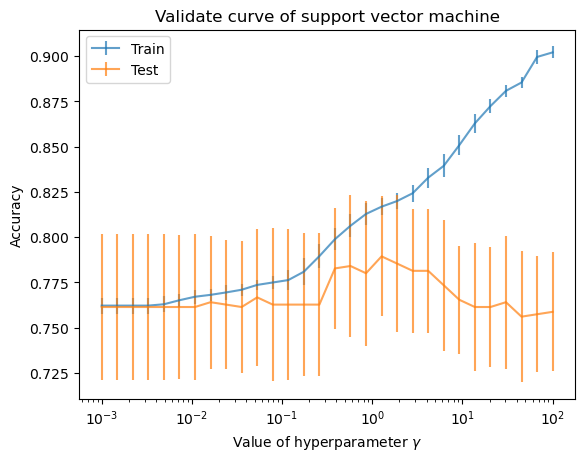

In [38]:

gamma_values = np.logspace(-3, 2, num=30) 

disp = ValidationCurveDisplay.from_estimator(
    model,
    data,
    target, 
    param_name="svc__gamma", # we need svc__gamma instead of just gamma because we are manipulating a `Pipeline` (?)
    param_range=gamma_values, 
    cv=cv, # we re-use the shuffle split from above
    scoring="accuracy",
    score_name="Accuracy",
    std_display_style="errorbar", # show the variability of the mean absolute error
    errorbar_kw={"alpha": 0.7},  # transparency for better visualization
    n_jobs=2,
)

_ = disp.ax_.set(
    xlabel="Value of hyperparameter $\gamma$",
    ylabel="Accuracy",
    title="Validate curve of support vector machine",
)

What do we see?
- overfitting starting around $\gamma$ = 1? (remember higher accuracy is better)


**(4) Compute the learning curve (using `sklearn.model_selection.LearningCurveDisplay`) by computing the train and test scores for different training dataset size.**

In [39]:
train_sizes = np.linspace(0.1, 1.0, num=10, endpoint=True) 

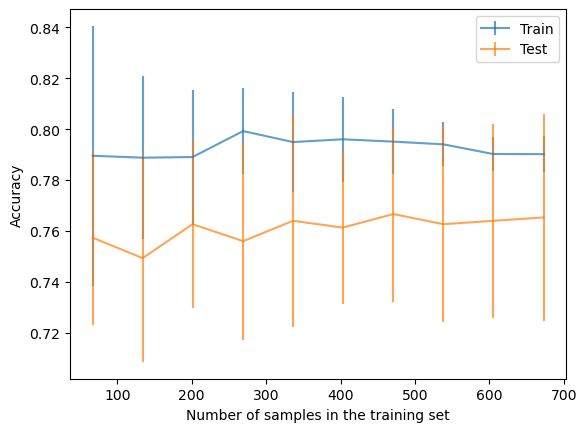

In [40]:
display = LearningCurveDisplay.from_estimator(
    model,
    data,
    target,
    train_sizes=train_sizes,
    cv=cv,
    scoring="accuracy",
    score_name="Accuracy",
    std_display_style="errorbar",
    errorbar_kw={"alpha": 0.7},  # transparency for better visualization
    n_jobs=2,
)
_ = disp.ax_.set(title="Learning curve for support vector machine")


Observations
- adding more samples does not improve the accuracy much -- it's always around 0.77
- note that this is about the fraction of records that are in class `"not donated"`. Therefore, even without seeing any data, the we could have a similar performance

Interpretation
- this suggests that this model here is probably too simple
- features themselves are not informative, for any model
- the other default hyperparameter values of `SVC` are not good
- the model itself may be wrong

### Quiz M2.02

**see the exercise document**

"Quiz: over- and underfitting and learning curves (5 minutes, in pairs; if time-permitting)"

**Solutions**
1.b, 2.a, 3.d, 4.b, 5.c/d, 6.b